# EVAC Examination

## Data Exploration

In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [388]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [389]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


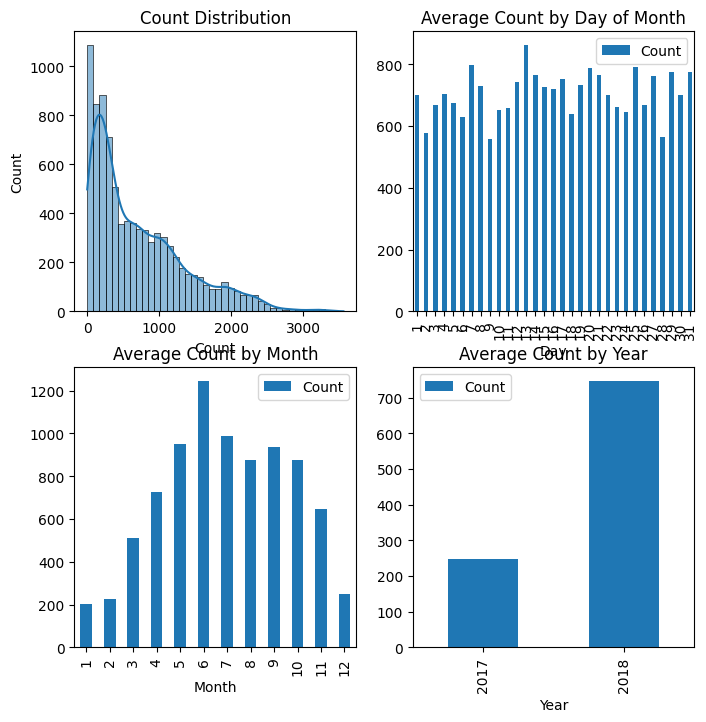

In [390]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [391]:
all_data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [392]:
!pip install deap

384991.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [393]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [394]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = evdata['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [395]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [396]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [397]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [398]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [399]:
def eval(individual, myNet, evdata):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(evdata)):
    input = [ evdata['Windspeed'][i], evdata['Visibility'][i], evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000000000,
    fitness += abs(evdata['Count'][i] - output[0])
  return fitness/len(evdata),


In [400]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.6)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet, train_data)
print(baseline)

(1000000000000000,)


In [401]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [402]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[-0.47971370091961396, 0.44607495538456865, -0.863122560089782, -0.9297234159201098, 0.025511668846266877, -0.17910417882979135, -0.1552413812662894, -0.7408168497668843, -0.6899177747453629, -0.15121259932113662, 0.008944555517247377, 0.6803987667566622, 0.6034796301595473, -0.2634135036502361, -0.9471663757982547, 0.6974605167419894, -0.3614221504070867, -0.5113867901448301, 0.16300989335735294, 0.8466919209092583, 0.5878542527208417, 0.89271114931164, -0.4792969973033392, -0.5329877351931529, -0.6699079560933039, -0.6576865953736473, -0.7269141459848987, -0.05759678487884523, 0.6349493089306346, 0.32144795734648524, 0.5846755884160839, -0.3924304646048249, 0.7171626366894552, -0.6384137049204885, 0.8451482462396911, -0.6898297690246036, -0.6257379234866434, 0.4899588499111087, -0.23996441628362786, -0.15132674141019442, 0.1423078853098083, 0.6582348311117525, 0.08984905091314555, 0.5200528436828709, 0.5142596667841872, 0.6764725492839172, -0.4732176947140314, 0.887690860184492, -0.9

In [403]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [404]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [405]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [406]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg    	gen	max  	min    	std        
4.6e+14	0  	1e+15	478.311	4.98397e+14
3.6e+14	1  	1e+15	462.124	4.8e+14    
3.7e+14	2  	1e+15	467.861	4.82804e+14
3.5e+14	3  	1e+15	453.974	4.7697e+14 
2.2e+14	4  	1e+15	457.613	4.14246e+14
3.4e+14	5  	1e+15	770.472	4.73709e+14
3.3e+14	6  	1e+15	433.987	4.70213e+14
2.8e+14	7  	1e+15	474.936	4.48999e+14
3.1e+14	8  	1e+15	724.157	4.62493e+14
1.5e+14	9  	1e+15	466.939	3.57071e+14
2.9e+14	10 	1e+15	494.366	4.53762e+14
3e+14  	11 	1e+15	430.091	4.58258e+14
3e+14  	12 	1e+15	499.603	4.58258e+14
2.9e+14	13 	1e+15	448.16 	4.53762e+14
2.7e+14	14 	1e+15	470.965	4.43959e+14
2e+14  	15 	1e+15	764.44 	4e+14      
3.5e+14	16 	1e+15	461.309	4.7697e+14 
2.9e+14	17 	1e+15	492.939	4.53762e+14
2.8e+14	18 	1e+15	540.167	4.48999e+14
2.4e+14	19 	1e+15	600.987	4.27083e+14
1.9e+14	20 	1e+15	676.554	3.92301e+14
2.7e+14	21 	1e+15	691.113	4.43959e+14
2.4e+14	22 	1e+15	665.254	4.27083e+14
2.2e+14	23 	1e+15	628.735	4.14246e+14
2.5e+14	24 	1e+15	462.823	4.33013e+14
2.6e+14	25 	

[0.13532436542815962, -3.7043278515921148, 4.375685947461327, -6.110205976833926, 0.6854788978952243, 3.527556355780063, -5.065142081983718, -0.10751190670361743, 4.392942323507147, 2.6248244338140614, 3.3492582261827732, 4.150414569755904, -6.323930633750805, 0.36395024408578436, -6.047935275399229, -3.06302149664364, -1.2307433220713577, -2.9327127658061976, 0.7490761070225285, -0.5937816668751092, -4.716674733121544, -8.577633866116686, -4.03623320674586, -3.394789460985256, -8.866534851724198, 0.17123198145067825, -12.251412581528763, -6.635766489059569, 11.270424924711078, -4.120733191929146, 8.041998236153587, 7.926289078587004, 4.589520138196207, -1.6450460688299, 3.284312590586854, -0.42652037481422583, 2.0487699524818606, -3.8175027573881133, -1.4940833167292198, 7.116102253684444, -3.294606504320769, -3.9803073129119646, -0.5531709804301097, 2.744802921461266, 4.651225221906954, 4.695022187760675, 11.800609081230848, 5.875664597821099, 11.317686647321075, -12.24125028732619, 

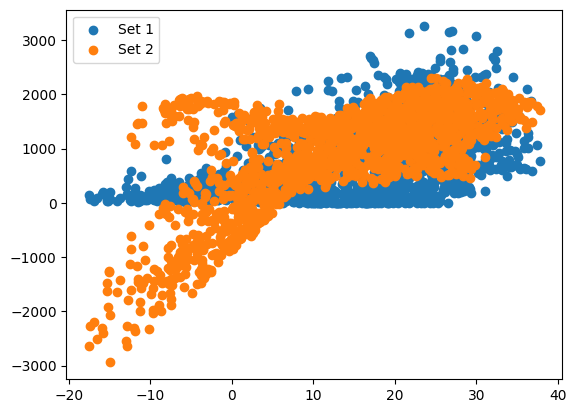

In [407]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))

inputs = [[test_data['Hour'][i],test_data['Temp'][i], test_data['Windspeed'][i], test_data['HireAvailable'][i], test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i]] for i in range(len(test_data))]
# Assuming you have two sets of data:
x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([1113.22936851]), array([1519.19976233]), array([883.23719879]), array([1916.51971944]), array([1321.08812741]), array([1241.89202649]), array([1289.96262135]), array([-1100.23941326]), array([817.1118203]), array([676.61464939]), array([-487.68408045]), array([1938.17914987]), array([-1048.32181628]), array([1194.58162358]), array([-0.61635212]), array([95.65368314]), array([689.47365358]), array([74.56438307]), array([1660.09807603]), array([1838.29356052]), array([205.79089569]), array([1341.82639489]), array([-160.6942114]), array([2077.2631607]), array([1273.37472645]), array([601.88180328]), array([717.73012137]), array([1705.18411642]), array([2037.09006116]), array([1454.23040464]), array([1631.45183876]), array([1562.51105725]), array([1589.80651089]), array([1798.69852396]), array([2003.00571611]), array([1403.89596297]), array([1353.89811442]), array([1224.57217799]), array([2006.27168513]), array([1587.81354817]), array([1848.7550658]), array([1821.11189271]), array(

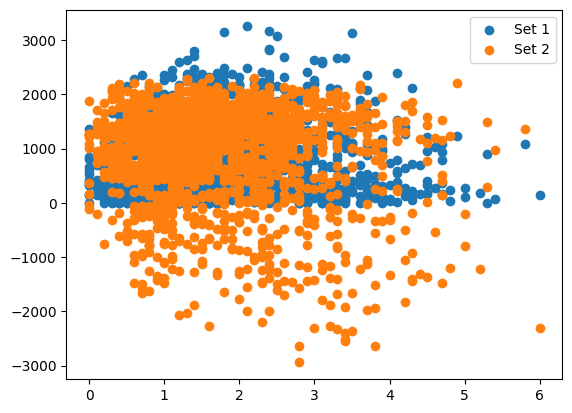

In [408]:
# Assuming you have two sets of data:
x_values1 = test_data['Windspeed'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([1113.22936851]), array([1519.19976233]), array([883.23719879]), array([1916.51971944]), array([1321.08812741]), array([1241.89202649]), array([1289.96262135]), array([-1100.23941326]), array([817.1118203]), array([676.61464939]), array([-487.68408045]), array([1938.17914987]), array([-1048.32181628]), array([1194.58162358]), array([-0.61635212]), array([95.65368314]), array([689.47365358]), array([74.56438307]), array([1660.09807603]), array([1838.29356052]), array([205.79089569]), array([1341.82639489]), array([-160.6942114]), array([2077.2631607]), array([1273.37472645]), array([601.88180328]), array([717.73012137]), array([1705.18411642]), array([2037.09006116]), array([1454.23040464]), array([1631.45183876]), array([1562.51105725]), array([1589.80651089]), array([1798.69852396]), array([2003.00571611]), array([1403.89596297]), array([1353.89811442]), array([1224.57217799]), array([2006.27168513]), array([1587.81354817]), array([1848.7550658]), array([1821.11189271]), array(

ValueError: x and y must be the same size

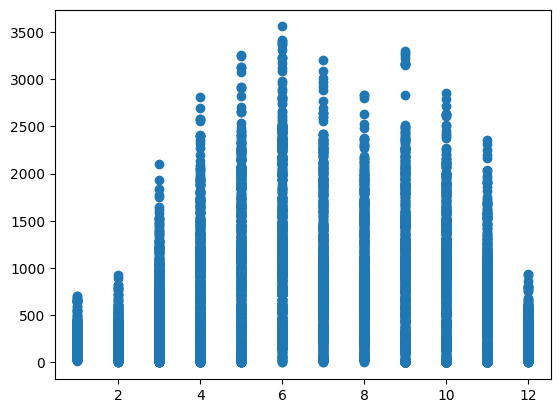

In [409]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()